# Vision Transformer (ViT) Implementation Using Pytorch

This notebook demonstrates the implementation of a Vision Transformer (ViT) from scratch using PyTorch. The Vision Transformer is a model for image classification that leverages the Transformer architecture, which has been highly successful in natural language processing tasks.

We will be using the CIFAR-10 dataset for training and evaluating our model. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images.

The implementation includes the following components:
- **Patcher**: Divides the input image into smaller patches.
- **LinearProjectionFlatten**: Projects the patches into a higher-dimensional space.
- **PositionalEncoder**: Adds positional information to the patches.
- **SelfAttention**: Implements the self-attention mechanism.
- **AttentionBlock**: Combines self-attention with linear projections.
- **TransformerEncoder**: Stacks multiple attention blocks with normalization and feed-forward layers.
- **MLPHead**: A simple feed-forward network for final classification.
- **VisionTransformer**: Combines all components to form the complete Vision Transformer model.

The model is trained on the CIFAR-10 dataset for 10 epochs using the Adam optimizer and cross-entropy loss. The training loss is plotted to visualize the training process, and the model's prediction for a sample image is compared with the true label.

### Import libraries

In [1]:
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import transforms
from einops import rearrange

## Prepare the Data (Cifar10)

In [2]:
# A simple transform for data since real focus is on ViT
transform = transforms.Compose([
    transforms.ToTensor()
])

# One-hot encoding the target labels
def one_hot_encode(label):
    return F.one_hot(torch.tensor(label), num_classes=10).float()

train_dataset = CIFAR10(
    root='../../../datasets',
    train=True,
    download=False, # Download the dataset if it does not exist
    transform=transform,
    target_transform=one_hot_encode
)

test_dataset = CIFAR10(
    root='../../../datasets',
    train=False,
    download=False, # Download the dataset if it does not exist
    transform=transform,
    target_transform=one_hot_encode
)

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In this notebook, we will implement the Vision Transformer (ViT) architecture as described in its original paper: ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929).

![Vision Transformer](ViT_Image_paper.png)


### Patcher

The `Patcher` class is responsible for dividing the input image into smaller patches. Each patch is then flattened into a vector.

In [4]:
class Patcher(nn.Module):
    def __init__(self, patch_size=16, embed_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

    def forward(self, x: Tensor):
        # Batch size, Num patches, Flatten features
        patches = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        return patches

### LinearProjectionFlatten

The `LinearProjectionFlatten` class takes the patches created by the `Patcher` and projects them into a higher-dimensional space using a linear layer.

In [5]:
class LinearProjectionFlatten(nn.Module):
    def __init__(self, patcher: Patcher, num_channels=3):
        super().__init__()
        self.patcher: Patcher = patcher
        self.patch_embedding = nn.Linear(num_channels * patcher.patch_size ** 2, patcher.embed_dim)

    def forward(self, x: Tensor):
        patches = self.patcher(x)
        embedded_patches = self.patch_embedding(patches)
        return embedded_patches

### PositionalEncoder

The `PositionalEncoder` class adds positional information to the patches, which helps the model understand the order of the patches.

In [6]:
class PositionalEncoder(nn.Module):
    def __init__(self, embed_dim=512, seq_len=5000):
        super().__init__()
        self.embed_dim = embed_dim

        position = torch.arange(0, seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))

        pe = torch.zeros(seq_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Using buffer to tell pytorch this is not learnable
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor):
        seq_len = x.size(1)

        x = x + self.pe[:seq_len, :].unsqueeze(dim=0)

        return x

### SelfAttention

The `SelfAttention` class implements the self-attention mechanism, which allows the model to focus on different parts of the input sequence.

In [7]:
class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def calculate_QKT(self, queries: Tensor, keys: Tensor):
        return torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(queries.shape[-1])
 
    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, 
                batch_size: int, seq_len: int, embed_dim: int, n_head: int):
        
        keys = keys.transpose(1, 2).contiguous().view(batch_size * n_head, seq_len, embed_dim)
        queries = queries.transpose(1, 2).contiguous().view(batch_size * n_head, seq_len, embed_dim)
        values = values.transpose(1, 2).contiguous().view(batch_size * n_head, seq_len, embed_dim)

        QKT = self.calculate_QKT(queries, keys)
        scores = F.softmax(QKT, dim=2)
        attention: Tensor = torch.bmm(scores, values).view(batch_size, n_head, seq_len, embed_dim)
        attention = attention.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim * n_head)
        return attention

### AttentionBlock

The `AttentionBlock` class combines the self-attention mechanism with linear projections to form a complete attention block.

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim=512, n_head=8):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_head = n_head

        # W for queries
        self.Wq = nn.Linear(embed_dim, embed_dim * n_head, bias=False)
        # W for keys
        self.Wk = nn.Linear(embed_dim, embed_dim * n_head, bias=False)
        # W for values
        self.Wv = nn.Linear(embed_dim, embed_dim * n_head, bias=False)
        # W for final results
        self.Wr = nn.Linear(embed_dim * n_head, embed_dim)

        self.attention = SelfAttention()

    def forward(self, x: Tensor):
        n_head = self.n_head
        batch_size, seq_len, embed_dim = x.size()

        queries = self.Wq(x).view(batch_size, seq_len, n_head, embed_dim)
        keys = self.Wk(x).view(batch_size, seq_len, n_head, embed_dim)
        values = self.Wv(x).view(batch_size, seq_len, n_head, embed_dim)

        result = self.attention(queries, keys, values, batch_size,
                                seq_len, embed_dim, n_head)
        
        return self.Wr(result)

### TransformerEncoder

The `TransformerEncoder` class stacks multiple attention blocks and adds normalization and feed-forward layers.

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=512, n_head=8):
        super().__init__()

        self.attention = AttentionBlock(embed_dim, n_head)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        hidden_size = embed_dim * 2
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_dim)
        )

    def forward(self, x: Tensor):
        sc = self.attention(x) # First skip connection
        x = self.norm1(x + sc)
        sc = self.mlp(x)
        out = self.norm2(x + sc) # Second skip connection
        return out

### MLPHead

The `MLPHead` class is a simple feed-forward network that produces the final classification logits.

In [10]:
class MLPHead(nn.Module):
    def __init__(self, n_classes, embed_dim=512):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(embed_dim, n_classes)
        )

    def forward(self, x: Tensor):
        x_pool = x.mean(dim=1)
        
        logits = self.layers(x_pool)
        
        return logits

### VisionTransformer

The `VisionTransformer` class combines all the components to form the complete Vision Transformer model.

In [11]:
class VisionTransformer(nn.Module):
    def __init__(self, n_classes, patch_size=16, seq_len=5000, n_head=8, embed_dim=512, num_channels=3, n_transformers=6):
        super().__init__()

        patcher = Patcher(patch_size, embed_dim)
        self.linear_flatter = LinearProjectionFlatten(patcher, num_channels)

        self.positional_encoding = PositionalEncoder(embed_dim, seq_len)

        transformer_encoders = [TransformerEncoder(embed_dim, n_head) for _ in range(n_transformers)]
        self.transformers = nn.Sequential(*transformer_encoders)

        self.mlp_head = MLPHead(n_classes, embed_dim)

    def forward(self, x: Tensor):
        flatten = self.linear_flatter(x)
        
        positional_encoded = self.positional_encoding(flatten)

        transform = self.transformers(positional_encoded)
        return self.mlp_head(transform)

### Set device

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Training the Model

The model is trained on the CIFAR-10 dataset for 10 epochs using the Adam optimizer and cross-entropy loss.

In [ ]:
model = VisionTransformer(n_classes=10, patch_size=4, seq_len=5000, n_head=8,
                        embed_dim=50, num_channels=3, n_transformers=6).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10

train_losses = []
test_losses = []

for epoch in tqdm(range(epochs)):  
    num_batches = len(train_dataloader)

    epoch_loss_train = 0
    model.train()

    for img, label in train_dataloader:
        img: Tensor = img.to(device)
        label: Tensor = label.to(device)

        logits: Tensor = model(img)
        loss: Tensor = loss_fn(logits, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss_train += loss.item()

    # Using test dataset as validation dataset
    epoch_loss_test = 0

    model.eval()
    with torch.no_grad():
        for img, label in test_dataloader:
            img: Tensor = img.to(device)
            label: Tensor = label.to(device)

            logits: Tensor = model(img)
            loss: Tensor = loss_fn(logits, label)

            epoch_loss_test = loss.item()

    epoch_loss_train /= num_batches
    epoch_loss_test /= num_batches
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}")

 10%|█         | 1/10 [00:39<05:54, 39.39s/it]

Epoch 1, Train Loss: 1.9835, Test Loss: 1.9835


 20%|██        | 2/10 [01:14<04:54, 36.84s/it]

Epoch 2, Train Loss: 1.6130, Test Loss: 1.6130


 30%|███       | 3/10 [01:50<04:14, 36.33s/it]

Epoch 3, Train Loss: 1.4168, Test Loss: 1.4168


 40%|████      | 4/10 [02:24<03:33, 35.55s/it]

Epoch 4, Train Loss: 1.3080, Test Loss: 1.3080


 50%|█████     | 5/10 [03:05<03:06, 37.39s/it]

Epoch 5, Train Loss: 1.2195, Test Loss: 1.2195


 60%|██████    | 6/10 [03:40<02:27, 36.85s/it]

Epoch 6, Train Loss: 1.1562, Test Loss: 1.1562


 70%|███████   | 7/10 [04:20<01:53, 37.76s/it]

Epoch 7, Train Loss: 1.0930, Test Loss: 1.0930


 80%|████████  | 8/10 [05:03<01:18, 39.36s/it]

Epoch 8, Train Loss: 1.0371, Test Loss: 1.0371


 90%|█████████ | 9/10 [05:38<00:37, 37.91s/it]

Epoch 9, Train Loss: 0.9898, Test Loss: 0.9898


 90%|█████████ | 9/10 [05:44<00:38, 38.25s/it]


KeyboardInterrupt: 

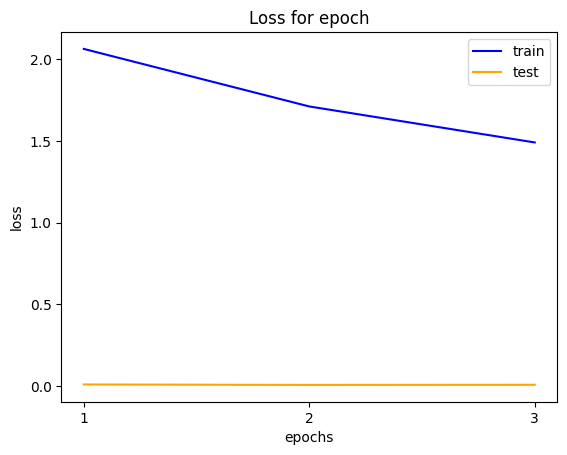

In [44]:
plt.plot(range(1, len(range(epochs)) + 1), train_losses, label='train', color='blue')
plt.plot(range(1, len(range(epochs)) + 1), test_losses, label='test', color='orange')
plt.legend()
plt.title('Loss for epoch')
plt.xticks(range(1, epochs + 1))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()